In [1]:
%matplotlib inline

import datetime as dt

import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

# Largest Context:
#sns.set_context("talk")

from metpy.calc import dewpoint_from_relative_humidity
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo
from metpy.units import units

import os

In [2]:
# Height of the station to calculate MSLP
hgt_example = 206.

def calc_mslp(t, p, h):
    return p * (1 - (0.0065 * h) / (t + 0.0065 * h + 273.15)) ** (-5.257)


testdata = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_1min - Copy.dat',header=1).drop([0,1])
testdata2 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_1min.dat',header=1).drop([0,1])
testdata3 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_2022_1min.dat',header=1).drop([0,1])

testdata_all = pd.concat([testdata,testdata2,testdata3]).replace('NAN',np.nan)

testdata_all['Time_Eastern'] = pd.to_datetime(testdata_all['TIMESTAMP'])+pd.Timedelta(value=1, unit='hours')
# testdata_all=testdata_all.set_index('Time_Eastern')

timestamps_est = np.array(testdata_all.Time_Eastern, dtype=dt.datetime)
temp_times = np.zeros(len(timestamps_est),dtype=dt.datetime)
for i in range(len(timestamps_est)):
    temp_times[i] = timestamps_est[i]+pd.Timedelta(value=5, unit='hours')

testdata_all['UTC'] = temp_times
testdata_all=testdata_all.set_index('UTC')

testdata_all['Geonor_Freq'][185486] = float("nan")
testdata_all['Current_Depth'][185486] = float("nan")
testdata_all['Precip_Rate'][185487] = float("nan")

testdata_all['Geonor_Freq'][204447] = float("nan")
testdata_all['Current_Depth'][204447] = float("nan")
testdata_all['Precip_Rate'][204448] = float("nan")

testdata_all['Geonor_Freq'][223988] = float("nan")
testdata_all['Current_Depth'][223988] = float("nan")
testdata_all['Precip_Rate'][223989] = float("nan")

testdata_all['Geonor_Freq'][255972] = float("nan")
testdata_all['Current_Depth'][255972] = float("nan")
testdata_all['Precip_Rate'][255973] = float("nan")

testdata_all['Geonor_Freq'][256036] = float("nan")
testdata_all['Current_Depth'][256036] = float("nan")
testdata_all['Precip_Rate'][256037] = float("nan")

testdata_all['Geonor_Freq'][264175] = float("nan")
testdata_all['Current_Depth'][264175] = float("nan")
testdata_all['Precip_Rate'][264176] = float("nan")

testdata_all['Geonor_Freq'][268822] = float("nan")
testdata_all['Current_Depth'][268822] = float("nan")
testdata_all['Precip_Rate'][268823] = float("nan")

/tmp/ipykernel_146207/3231661613.py:9: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  testdata2 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_1min.dat',header=1).drop([0,1])
/tmp/ipykernel_146207/3231661613.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  testdata3 = pd.read_csv('/data/accp/a/snesbitt/scamp-2023/LoggerNet/SCAMPCR6_SCAMP_2022_1min.dat',header=1).drop([0,1])
/tmp/ipykernel_146207/3231661613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata_all['Geonor_Freq'][185486] = float("nan")
/tmp/ipykernel_146207/3231661613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [2]:
#2021-2022 dates
#dates = pd.date_range(start='2021-11-23',end='2022-03-02')
#Gauge dates
#dates = pd.date_range(start='2021-12-01',end='2022-03-02')

#2022-2023 dates
dates = pd.date_range(start='2022-11-13',end='2023-03-04')

freq = pd.to_numeric(testdata['Geonor_Freq'],errors='coerce')
date = pd.to_datetime(testdata.index) #+ dt.timedelta(hours=1)

for idate in dates:
  
    t1=idate
    t2=idate+pd.Timedelta(1, unit='D')
    mask = (testdata_all.index >= t1) & (testdata_all.index <= t2)

    if mask.sum() > 0:

        testdata = testdata_all.loc[mask]

        precip_temp = pd.to_numeric(testdata['Current_Depth'],errors='coerce')
        precip_rate_temp = np.diff(pd.to_numeric(testdata['Current_Depth'],errors='coerce'))
        precip_rate_temp[precip_rate_temp < 0.05] = 0.
        precip_rate_temp = np.concatenate([[0],precip_rate_temp],axis=0)
        precip_daily_temp = np.cumsum(precip_rate_temp)
        freq_temp = pd.to_numeric(testdata['Geonor_Freq'],errors='coerce')
        date_temp = pd.to_datetime(testdata.index) #+ dt.timedelta(hours=1)

        if idate == dates[0]:
            precip_daily = precip_daily_temp
            precip = precip_temp
            freq = freq_temp
            date = date_temp
            precip_rate = precip_rate_temp

        else:
            precip_daily = np.concatenate((precip_daily,precip_daily_temp))
            precip = np.concatenate((precip,precip_temp))
            precip_rate = np.concatenate((precip_rate,precip_rate_temp))
            freq = np.concatenate((freq,freq_temp))
            date = np.concatenate((date,date_temp))
    
data = pd.DataFrame({'Precipitation rate (mm/hr)': np.array(precip_rate*60)* units('mm'),
        'Precip': np.array(precip),
        'Precip accumulation (mm)': np.array(precip_daily)* units('mm'), 'times': np.array(date),
        'Frequency': np.array(freq)})
data.index=date

NameError: name 'testdata' is not defined

Text(0.5, 0.9, 'UIUC SCAMP Geonor Gauge: 20221113 00:00 to 20230304 00:00 UTC')

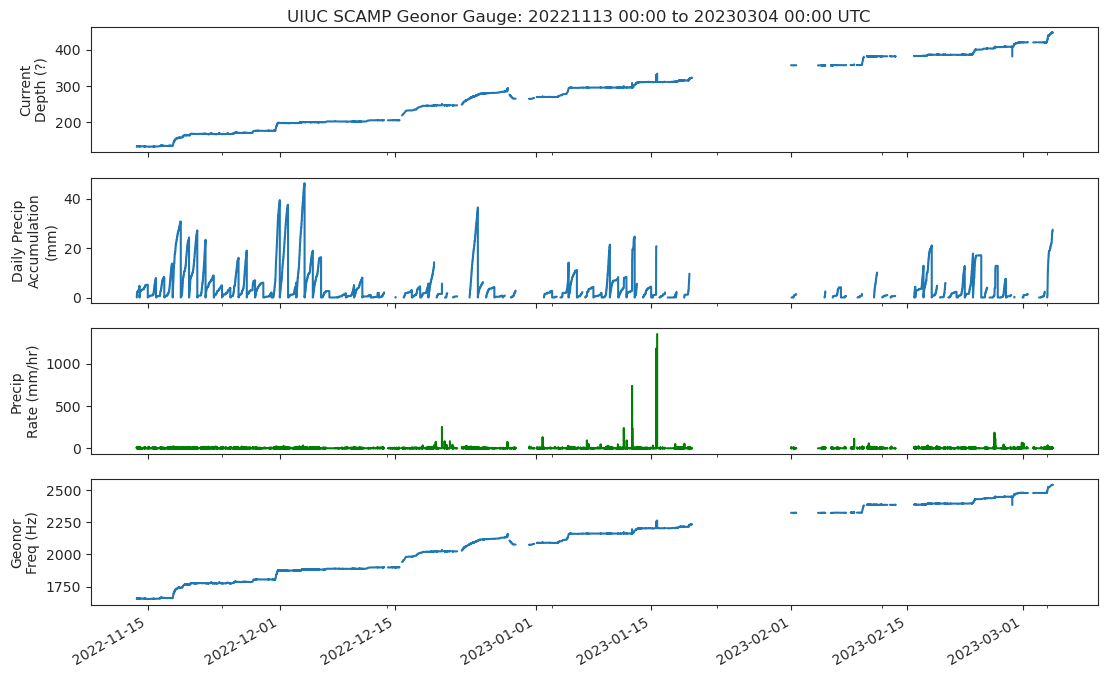

In [4]:
fig = plt.figure(figsize=(13,8.5))

ax=fig.subplots(nrows=4,ncols=1,sharex=True)

data['Precip'].plot(ax=ax[0])
ax[0].set_ylabel('Current\nDepth (?)')

#ax[1].scatter(data.index,data['Precipitation rate (mm/hr)'])
data['Precip accumulation (mm)'].plot(ax=ax[1])
ax[1].set_ylabel('Daily Precip\nAccumulation\n(mm)')
#ax[1].set_ylim([-1,50])

data['Precipitation rate (mm/hr)'].plot(ax=ax[2],color='g')
ax[2].set_ylabel('Precip\nRate (mm/hr)')
#ax[2].set_ylim([-1,5])

data['Frequency'].plot(ax=ax[3])
ax[3].set_ylabel('Geonor\nFreq (Hz)')
#ax[3].set_ylim([2150,2250])


fig.suptitle('UIUC SCAMP Geonor Gauge: '+dates[0].strftime('%Y%m%d %H:%M')+' to '+dates[len(dates)-1].strftime('%Y%m%d %H:%M')+' UTC', y=0.90)

        #plt.savefig('/data/accp/a/snesbitt/scamp/logger/images2/'+t1.strftime('%Y%m%d_%H:%M_SCAMPwxstn'+'.png'),dpi=150)

#plt.close()

In [5]:
'''
#Once only used for single day data plotting purposes
dates = pd.date_range(start='2022-12-01',end='2022-12-01')

t1=dates[0]
t2=dates[0] + pd.Timedelta(len(dates), unit='D')
mask = (testdata_all.index >= t1) & (testdata_all.index <= t2)
print(t1, t2, mask.sum())

testdata = testdata_all.loc[mask]

        # Temporary variables for ease
precip = pd.to_numeric(testdata['Current_Depth'],errors='coerce')
precip_rate = np.diff(pd.to_numeric(testdata['Current_Depth'],errors='coerce'))
precip_rate[precip_rate < 0.05] = 0.
precip_rate = np.concatenate([[0],precip_rate],axis=0)
#precip_daily = np.cumsum(precip_rate)
freq = pd.to_numeric(testdata['Geonor_Freq'],errors='coerce')
date = pd.to_datetime(testdata.index) #+ dt.timedelta(hours=1)

for idate in dates:
  
    t1=idate
    t2=idate+pd.Timedelta(1, unit='D')
    mask = (testdata_all.index >= t1) & (testdata_all.index <= t2)
    print(t1, t2, mask.sum())

    #if mask.sum() > 0:

    testdata = testdata_all.loc[mask]

    precip_rate_temp = np.diff(pd.to_numeric(testdata['Current_Depth'],errors='coerce'))
    precip_rate_temp[precip_rate_temp < 0.05] = 0.
    precip_rate_temp = np.concatenate([[0],precip_rate_temp],axis=0)
    precip_daily_temp = np.cumsum(precip_rate_temp)
    if idate == dates[0]:
        precip_daily = precip_daily_temp
    else:
        precip_daily = np.concatenate((precip_daily,precip_daily_temp))
    
data = pd.DataFrame({'Precipitation rate (mm/hr)': np.array(precip_rate*60)* units('mm'),
        'Precip': np.array(precip),
        'Precip accumulation (mm)': np.array(precip_daily)* units('mm'), 'times': np.array(date),
        'Frequency': np.array(freq)})
data.index=date

'''

"\n#Once only used for single day data plotting purposes\ndates = pd.date_range(start='2022-12-01',end='2022-12-01')\n\nt1=dates[0]\nt2=dates[0] + pd.Timedelta(len(dates), unit='D')\nmask = (testdata_all.index >= t1) & (testdata_all.index <= t2)\nprint(t1, t2, mask.sum())\n\ntestdata = testdata_all.loc[mask]\n\n        # Temporary variables for ease\nprecip = pd.to_numeric(testdata['Current_Depth'],errors='coerce')\nprecip_rate = np.diff(pd.to_numeric(testdata['Current_Depth'],errors='coerce'))\nprecip_rate[precip_rate < 0.05] = 0.\nprecip_rate = np.concatenate([[0],precip_rate],axis=0)\n#precip_daily = np.cumsum(precip_rate)\nfreq = pd.to_numeric(testdata['Geonor_Freq'],errors='coerce')\ndate = pd.to_datetime(testdata.index) #+ dt.timedelta(hours=1)\n\nfor idate in dates:\n  \n    t1=idate\n    t2=idate+pd.Timedelta(1, unit='D')\n    mask = (testdata_all.index >= t1) & (testdata_all.index <= t2)\n    print(t1, t2, mask.sum())\n\n    #if mask.sum() > 0:\n\n    testdata = testdata_all.l

In [6]:
testdata_all.iloc[264175:264178]


,TIMESTAMP,RECORD,PTemp_Avg,Batt_Volt_Avg,Air_Temp_Avg,Rel_Hum_Avg,Abs_Pressure_Avg,Wspd_Avg,Wdir_Vct,Geonor_Freq,Geonor_Depth_Raw,Current_Depth,Depth_1min,Precip_Rate,Wspd_Max,Time_Eastern
UTC,,,,,,,,,,,,,,,,
2023-02-10 08:24:00,2023-02-10 02:24:00,9626,7.014,13.28,3.4,84.7,983.0,8.0,253.5,NaN,112.1449,NaN,0,0,13.6,2023-02-10 03:24:00
2023-02-10 08:25:00,2023-02-10 02:25:00,9627,6.997,13.28,3.4,84.7,983.0,11.0,253.0,2382.828,381.8452,381.8452,269.7003,NaN,17.3,2023-02-10 03:25:00
2023-02-10 08:26:00,2023-02-10 02:26:00,9628,6.98,13.28,3.4,84.5,983.0,11.0,252.8,2382.724,381.8024,381.8024,0,0,12.4,2023-02-10 03:26:00
